# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a **polygon matching procedure**. 

For this project, I am comparing the performance of a polygon matching process, both before and after implementing optimizations. I am using terms like **_"geospatial-native"_** or **_"geosptially-optimized"_** when describing the improved method. A **_geospatially-optimized_** approach uses the latest tools and techniques to make geospatial data processing efficient, while a **_"geospatially-naive"_** or a **_"geospatially non-optimized"_** approach as one that does not take full advantage of the latest advances in geospatial data engineering and analysis.

There are two main areas that could benefit from taking a geospatial-native approach:

1. Data encoding, fetching, and storage
2. Searching for overlaps

I use both a non-geospatial-native and geospatial-native approach to matching blos in a dataset. We will benchmark the execution time, CPU usage, and memory usage for both to see how they differ, with the implicit hypothesis being that the geospatial-native approaches will be more efficient and process more quickly.

Therefore, this project is divided into **two parts**:

1. **Geospatially-non-optimized**
   * Encoding spatial data as strings
   * Storing data in a Postgres database
   * Using GeoPandas for polygon matching
2. **Geospatially-optimized**
   * Replace geohash index with H3
   * Under construction...

## Imports

In [2]:
import geopandas as gpd
import pandas as pd
import shapely
import h3
import time
import helpers as h
import parallel_processing as p
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.wkt import dumps, loads
from shapely.geometry import box
from pathlib import Path
import multiprocessing as mp
import datetime
import psycopg2
from psycopg2 import sql, extras
import random
import duckdb
duckdb.sql('INSTALL spatial;')
duckdb.sql('LOAD spatial;')
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import blob_search_functions as b

# ensure helper scripts are loaded correctly as I work on them
import importlib
importlib.reload(h)
importlib.reload(p)
importlib.reload(b)

<module 'blob_search_functions' from '/Users/sra/files/projects/revealgc/matching_optimization/blob_search_functions.py'>

## Retrieve Data

As part of the project, I previously downloaded a 600,000-row slice of data where the `YEAR` = 2024 and the `MONTH` is between March and July.

Go to [this notebook](retrieve_and_concat_data.ipynb) to see my work in [retrieving](retrieve_and_concat_data.ipynb#download) and [converting](retrieve_and_concat_data.ipynb#concat) the data.

The `geometry` column stores the spatial information, which is sourced from the `BLOB_POLYGON` column within the same table.

In [39]:
gdf_path = Path('data/blob_20250307.parquet')
gdf = gpd.read_parquet(gdf_path)
gdf.head()

,BLOB_ID,FULL_IMG_ID,POINT,SIZE,POLYGON_BOUNDRY_BOX,BLOB_POLYGON,GEO_HASHES,CONSTRUCTION_STAGE,BUILDING_TYPE,CS_MODEL_ID,...,IS_VALID,IS_IMPUTED,IS_EXCLUDED,COUNTY,IS_OVERLAPPING_FOOTPRINT,IS_OVERLAPPING_ROAD,FOOTPRINT_ID,ROAD_DATA_ID,pgt_ctid,geometry
0,BID_4b0de362-432b-4169-880b-2502fe191e45,FIID_eeca1e04-8ba1-43cb-931c-81c560491477_2024...,POINT (-96.57220292317847 32.777977159601775),519,POLYGON ((-96.57224768518518 32.77805324074072...,POLYGON ((-96.57224768518518 32.77797916666665...,9vg66rn,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,DALLAS,True,False,FP_ID_36b25e18-56d6-482d-8f54-dac7c70c6687,None,"(1000,6)","POLYGON ((-96.57225 32.77798, -96.57224 32.777..."
1,BID_8ae754b5-026d-4aac-9b9c-7b473bcf1f79,FIID_46cf3f0f-2345-41e0-8e50-fcf561da16c4_2024...,POINT (-95.33409120370364 29.674920974576246),1180,POLYGON ((-95.33415972222215 29.67505787037034...,POLYGON ((-95.33415972222215 29.67503935185182...,9vk0yd5,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,HARRIS,True,False,FP_ID_c7fa7535-5ebb-4132-9814-e695c737a316,None,"(1000000,6)","POLYGON ((-95.33416 29.67504, -95.33416 29.675..."
2,BID_ea519744-3092-4bb3-a340-19afe400056f,FIID_f7968076-35bc-42c8-b417-f88e8fafd619_2024...,POINT (-96.74267940156228 33.196998841454544),1017,POLYGON ((-96.74277546296292 33.19707175925927...,POLYGON ((-96.74277546296292 33.19699305555556...,9vghye6,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,COLLIN,True,False,FP_ID_6f9bcbaf-4075-4ceb-aab1-ccdc562744e7,None,"(10000001,2)","POLYGON ((-96.74278 33.19699, -96.74277 33.196..."
3,BID_ea962ddc-c9ad-4a0a-905e-2012e0d6485d,FIID_a2ae6d14-612c-4123-bd66-636f6821c091_2024...,POINT (-96.72505400860906 33.16324660904856),826,POLYGON ((-96.72512731481478 33.16331712962967...,POLYGON ((-96.72512731481478 33.16324768518522...,9vghwvp|9vghwvn,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,COLLIN,True,False,FP_ID_3d617f10-f756-462f-b098-00badc42438a,None,"(10000002,6)","POLYGON ((-96.72513 33.16325, -96.72512 33.163..."
4,BID_ea9a59f0-7f15-4371-ac86-096cf4eeaf3f,FIID_f7968076-35bc-42c8-b417-f88e8fafd619_2024...,POINT (-96.7388098211761 33.202477229997186),1310,POLYGON ((-96.73887731481477 33.20259027777779...,POLYGON ((-96.73887731481477 33.20255787037038...,9vghysm|9vghysk,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,COLLIN,True,False,FP_ID_3aa44e93-ea83-4f15-b570-078dad879910,None,"(10000003,2)","POLYGON ((-96.73888 33.20256, -96.73887 33.202..."


View the data in a plot:

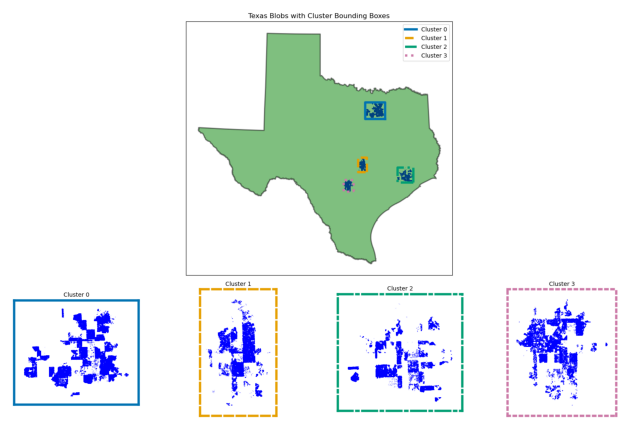

In [40]:
figure_path = Path('figs/blob_map_with_clusters.png')
if not figure_path.exists():
    # Reproject to a Texas-appropriate projected CRS (EPSG:3083)
    gdf_projected = gdf.to_crs("EPSG:3083")
    print("computing centroids after reprojection")
    gdf_projected['centroid'] = gdf_projected.geometry.centroid
    gdf_projected['centroid_x'] = gdf_projected.centroid.x
    gdf_projected['centroid_y'] = gdf_projected.centroid.y

    # Run k-means clustering (ensure coordinates are in a projected CRS if precision matters)
    print('running kmeans')
    X = gdf_projected[['centroid_x', 'centroid_y']].values
    kmeans = KMeans(n_clusters=4, random_state=42)
    gdf_projected['cluster'] = kmeans.fit_predict(X)

    # Compute bounding boxes for each cluster
    print('compute boxes')
    clusters = {}
    for cluster_label, group in gdf_projected.groupby('cluster'):
        minx, miny, maxx, maxy = group.total_bounds
        clusters[cluster_label] = box(minx, miny, maxx, maxy)

    # Define unique line styles and colors (Okabe–Ito palette)
    line_styles = ['-', '--', '-.', ':']
    line_colors = ['#0072B2', '#E69F00', '#009E73', '#CC79A7']

    # Plotting main Texas boundary, the polygons, and the bounding boxes
    print('plotting main texas boundary')
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    # Main plot
    print('main plot')
    ax_main = fig.add_subplot(gs[0])
    gdf_projected.plot(ax=ax_main, facecolor='none', edgecolor='blue', linewidth=1)

    # Plot the Texas boundary
    texas_boundary = gpd.read_file('data/Texas_State_Boundary_1106215059088919288.geojson')
    texas_boundary = texas_boundary.to_crs("EPSG:3083")
    texas_boundary.plot(ax=ax_main, alpha=0.5, color='green', edgecolor='black', linewidth=2)

    # Plot bounding boxes with unique line styles and colors
    for cluster_label, bbox in clusters.items():
        xs, ys = bbox.exterior.xy
        style = line_styles[cluster_label % len(line_styles)]
        color = line_colors[cluster_label % len(line_colors)]
        ax_main.plot(xs, ys, color=color, linestyle=style, linewidth=4, label=f'Cluster {cluster_label}')

    ax_main.set_title('Texas Blobs with Cluster Bounding Boxes')
    ax_main.legend()
    ax_main.set_xticks([])
    ax_main.set_yticks([])

    # Create subplots for each cluster
    print('create subplots for each cluster')
    gs_sub = gridspec.GridSpecFromSubplotSpec(
        nrows=1, 
        ncols=4, 
        subplot_spec=gs[1],
        wspace=0.3)

    for cluster_label, group in gdf_projected.groupby('cluster'):
        ax = fig.add_subplot(gs_sub[cluster_label])
        group.plot(ax=ax, facecolor='none', edgecolor='blue')
        # Adjust view to the cluster bounding box with a little buffer
        minx, miny, maxx, maxy = group.total_bounds
        x_buffer = (maxx - minx) * 0.1
        y_buffer = (maxy - miny) * 0.1
        ax.set_xlim(minx - x_buffer, maxx + x_buffer)
        ax.set_ylim(miny - y_buffer, maxy + y_buffer)
        ax.set_title(f'Cluster {cluster_label}', fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Update the axis spines to have the same style and color as the cluster's bounding box
        style = line_styles[cluster_label % len(line_styles)]
        color = line_colors[cluster_label % len(line_colors)]
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linestyle(style)
            spine.set_linewidth(4)

        # # Draw the corresponding bounding box on the subplot
        # bbox = clusters[cluster_label]
        # bxmin, bymin, bxmax, bymax = bbox.bounds
        # width = bxmax - bxmin
        # height = bymax - bymin
        # style = line_styles[cluster_label % len(line_styles)]
        # color = line_colors[cluster_label % len(line_colors)]
        # rect = plt.Rectangle((bxmin, bymin), width, height, fill=False, 
        #                      edgecolor=color, linestyle=style, linewidth=4)
        # ax.add_patch(rect)

    plt.tight_layout()
    plt.savefig('figs/blob_map_with_clusters.png', bbox_inches='tight')
    plt.show()
else:
    img = plt.imread(figure_path)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

The blobs seem to be located in four major cities in Texas: Dallas, Austin, Houston, and San Antonio.

Plot sample of blobs to inspect their shape:

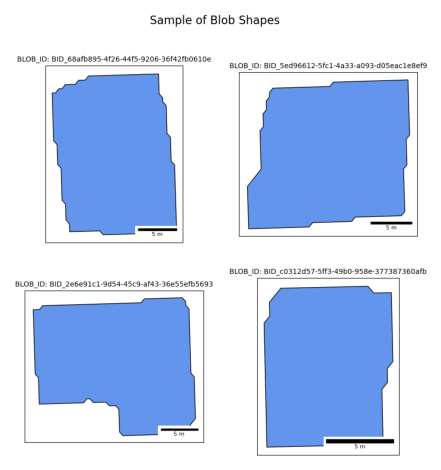

In [41]:
# File path for the output figure
figure_path = Path('figs/blob_samples.png')

if not figure_path.exists():
    # Sample random rows from the GeoDataFrame
    sample_size = 4
    gdf_sample = gdf.sample(n=sample_size, random_state=42)
    
    # Reproject the sample to a metric CRS (e.g., EPSG:3083 for Texas)
    gdf_sample = gdf_sample.to_crs("EPSG:3083")
    
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten to iterate easily

    # Define scale bar parameters.
    # Here, scale_length = 50 means a 50 meter scale bar.
    scale_length = 5  
    fontprops = fm.FontProperties(size=8)

    # Plot each sample polygon on its subplot and add a scale bar
    for ax, (idx, row) in zip(axes, gdf_sample.iterrows()):
        # Plot the single geometry
        gdf_sample[gdf_sample.index == idx].plot(ax=ax, facecolor='cornflowerblue', edgecolor='black')
        ax.set_title(f"BLOB_ID: {str(row['BLOB_ID'])}", fontdict={'fontsize':10})
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a scale bar using AnchoredSizeBar.
        # Label in meters rather than converting to km.
        scalebar = AnchoredSizeBar(ax.transData,
                                   scale_length,
                                   f'{scale_length} m',
                                   'lower right',
                                   pad=0.5,
                                   borderpad=0.5,
                                   color='black',
                                   frameon=True,
                                   size_vertical=scale_length/20,
                                   fontproperties=fontprops)
        scalebar.patch.set_facecolor('white')
        scalebar.patch.set_edgecolor('none')
        ax.add_artist(scalebar)

    # Set an overall title for the figure
    fig.suptitle("Sample of Blob Shapes", fontsize=16)
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('figs/blob_samples.png', bbox_inches='tight')
    plt.show()
else:
    img = plt.imread(figure_path)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

It's important to note that the blobs are extremely small, and their shapes are complex with many vertices. This will increase the storage requirements and retrieval times.

## 1. Non-optimized process

### 1.1. Data encoding, storage, and fetching

We will use PostgreSQL and string storage for geographic information.

#### Make copy of polygon layer and convert to non-geospatial-native string datatype (WKT)

In [76]:
# convert WKT versions to strings
gdf_wkt = h.convert_geom_columns_to_string(gdf)

# check result
gdf_wkt.head(1)

Function `convert_geom_columns_to_string` executed in 12.0129 sec, CPU: 11.60%, Memory: 1053.86MB


/Users/sra/files/projects/matching_optimization/helpers.py:269: UserWarning: Geometry column does not contain geometry.
  postgresql_details (dict): Connection details for the PostgreSQL instance.


,BLOB_ID,FULL_IMG_ID,POINT,SIZE,POLYGON_BOUNDRY_BOX,BLOB_POLYGON,GEO_HASHES,CONSTRUCTION_STAGE,BUILDING_TYPE,CS_MODEL_ID,...,IS_VALID,IS_IMPUTED,IS_EXCLUDED,COUNTY,IS_OVERLAPPING_FOOTPRINT,IS_OVERLAPPING_ROAD,FOOTPRINT_ID,ROAD_DATA_ID,pgt_ctid,geometry
0,BID_4b0de362-432b-4169-880b-2502fe191e45,FIID_eeca1e04-8ba1-43cb-931c-81c560491477_2024...,POINT (-96.57220292317847 32.777977159601775),519,POLYGON ((-96.57224768518518 32.77805324074072...,POLYGON ((-96.57224768518518 32.77797916666665...,9vg66rn,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,DALLAS,True,False,FP_ID_36b25e18-56d6-482d-8f54-dac7c70c6687,None,"(1000,6)","POLYGON ((-96.572248 32.777979, -96.572243 32...."


Confirm that conversion worked. The table should look very similar:

In [77]:
# original data
gdf.head(1)

,BLOB_ID,FULL_IMG_ID,POINT,SIZE,POLYGON_BOUNDRY_BOX,BLOB_POLYGON,GEO_HASHES,CONSTRUCTION_STAGE,BUILDING_TYPE,CS_MODEL_ID,...,IS_VALID,IS_IMPUTED,IS_EXCLUDED,COUNTY,IS_OVERLAPPING_FOOTPRINT,IS_OVERLAPPING_ROAD,FOOTPRINT_ID,ROAD_DATA_ID,pgt_ctid,geometry
0,BID_4b0de362-432b-4169-880b-2502fe191e45,FIID_eeca1e04-8ba1-43cb-931c-81c560491477_2024...,POINT (-96.57220292317847 32.777977159601775),519,POLYGON ((-96.57224768518518 32.77805324074072...,POLYGON ((-96.57224768518518 32.77797916666665...,9vg66rn,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,DALLAS,True,False,FP_ID_36b25e18-56d6-482d-8f54-dac7c70c6687,None,"(1000,6)","POLYGON ((-96.57225 32.77798, -96.57224 32.777..."


#### Save in PostgreSQL database

Create PostgreSQL database if it doesn't exist already. We will be using the default settings. If they need to be adjusted, refer to [`helpers.py`](helpers.py).

In [59]:
h.create_pg_db()

Database blob_matching already exists.
Function `create_pg_db` executed in 0.0839 sec, CPU: 33.80%, Memory: 52.81MB


Create and insert into tables:

In [8]:
gdf_footprints = pd.read_parquet('data/9vgm0_footprint.parquet')
gdf_blob = pd.read_parquet('data/9vgm0_blob.parquet')

In [11]:
# debug
# importlib.reload(h)
# print(f"DEBUG: Type of gdf_wkt: {type(gdf_wkt)}")
# print("DEBUG: DataFrame columns:", list(gdf_wkt.columns))
# print("DEBUG: DataFrame dtypes:")
# print(gdf_wkt.dtypes)

h.create_pg_table(
    table_name='footprints',
    # data=gdf_wkt,
    data=gdf_footprints,
    truncate=True
)

Function `generate_pg_schema` executed in 0.0006 sec, CPU: 83.30%, Memory: 0.22MB
Table footprints truncated.
Inserted 9300 records into footprints.
Function `create_pg_table` executed in 0.6205 sec, CPU: 16.60%, Memory: 9.23MB


In [13]:
h.create_pg_table(
    table_name='blobs',
    data=gdf_blob,
    truncate=True
)

Function `generate_pg_schema` executed in 0.0023 sec, CPU: 68.70%, Memory: 3.16MB
Table blobs truncated.
Inserted 13947 records into blobs.
Function `create_pg_table` executed in 2.0661 sec, CPU: 16.50%, Memory: 18.69MB


Retrieve data as GeoDataFrames to confirm that it worked:

In [5]:
# importlib.reload(h)

gdf_test = h.retrieve_pg_table(table_name='blobs')

Retrieved 600000 records from blobs.
Function `retrieve_pg_table` executed in 44.0905 sec, CPU: 7.80%, Memory: 762.78MB


In [7]:
# get count of rows in each month
duckdb.register('gdf_test', gdf_test)

check = duckdb.sql("""
    select MONTH, count(*)
    from gdf_test
    group by MONTH
    order by MONTH
""").to_df()

check

,month,count_star()
0,03,1557
1,04,14
2,05,118
3,06,516711
4,07,81600


Compare the tables before and after for a sanity check:

In [91]:
gdf_test.head(3)

,blob_id,full_img_id,point,size,polygon_boundry_box,blob_polygon,geo_hashes,construction_stage,building_type,cs_model_id,...,is_valid,is_imputed,is_excluded,county,is_overlapping_footprint,is_overlapping_road,footprint_id,road_data_id,pgt_ctid,geometry
0,BID_4b0de362-432b-4169-880b-2502fe191e45,FIID_eeca1e04-8ba1-43cb-931c-81c560491477_2024...,POINT (-96.57220292317847 32.777977159601775),519,POLYGON ((-96.57224768518518 32.77805324074072...,POLYGON ((-96.57224768518518 32.77797916666665...,9vg66rn,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,DALLAS,True,False,FP_ID_36b25e18-56d6-482d-8f54-dac7c70c6687,None,"(1000,6)","POLYGON ((-96.572248 32.777979, -96.572243 32...."
1,BID_8ae754b5-026d-4aac-9b9c-7b473bcf1f79,FIID_46cf3f0f-2345-41e0-8e50-fcf561da16c4_2024...,POINT (-95.33409120370364 29.674920974576246),1180,POLYGON ((-95.33415972222215 29.67505787037034...,POLYGON ((-95.33415972222215 29.67503935185182...,9vk0yd5,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,HARRIS,True,False,FP_ID_c7fa7535-5ebb-4132-9814-e695c737a316,None,"(1000000,6)","POLYGON ((-95.33416 29.675039, -95.334155 29.6..."
2,BID_ea519744-3092-4bb3-a340-19afe400056f,FIID_f7968076-35bc-42c8-b417-f88e8fafd619_2024...,POINT (-96.74267940156228 33.196998841454544),1017,POLYGON ((-96.74277546296292 33.19707175925927...,POLYGON ((-96.74277546296292 33.19699305555556...,9vghye6,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,COLLIN,True,False,FP_ID_6f9bcbaf-4075-4ceb-aab1-ccdc562744e7,None,"(10000001,2)","POLYGON ((-96.742775 33.196993, -96.742766 33...."


In [92]:
gdf.head(3)

,BLOB_ID,FULL_IMG_ID,POINT,SIZE,POLYGON_BOUNDRY_BOX,BLOB_POLYGON,GEO_HASHES,CONSTRUCTION_STAGE,BUILDING_TYPE,CS_MODEL_ID,...,IS_VALID,IS_IMPUTED,IS_EXCLUDED,COUNTY,IS_OVERLAPPING_FOOTPRINT,IS_OVERLAPPING_ROAD,FOOTPRINT_ID,ROAD_DATA_ID,pgt_ctid,geometry
0,BID_4b0de362-432b-4169-880b-2502fe191e45,FIID_eeca1e04-8ba1-43cb-931c-81c560491477_2024...,POINT (-96.57220292317847 32.777977159601775),519,POLYGON ((-96.57224768518518 32.77805324074072...,POLYGON ((-96.57224768518518 32.77797916666665...,9vg66rn,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,DALLAS,True,False,FP_ID_36b25e18-56d6-482d-8f54-dac7c70c6687,None,"(1000,6)","POLYGON ((-96.57225 32.77798, -96.57224 32.777..."
1,BID_8ae754b5-026d-4aac-9b9c-7b473bcf1f79,FIID_46cf3f0f-2345-41e0-8e50-fcf561da16c4_2024...,POINT (-95.33409120370364 29.674920974576246),1180,POLYGON ((-95.33415972222215 29.67505787037034...,POLYGON ((-95.33415972222215 29.67503935185182...,9vk0yd5,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,HARRIS,True,False,FP_ID_c7fa7535-5ebb-4132-9814-e695c737a316,None,"(1000000,6)","POLYGON ((-95.33416 29.67504, -95.33416 29.675..."
2,BID_ea519744-3092-4bb3-a340-19afe400056f,FIID_f7968076-35bc-42c8-b417-f88e8fafd619_2024...,POINT (-96.74267940156228 33.196998841454544),1017,POLYGON ((-96.74277546296292 33.19707175925927...,POLYGON ((-96.74277546296292 33.19699305555556...,9vghye6,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,COLLIN,True,False,FP_ID_6f9bcbaf-4075-4ceb-aab1-ccdc562744e7,None,"(10000001,2)","POLYGON ((-96.74278 33.19699, -96.74277 33.196..."


Confirm that the original blob df and the retrieved df are the same length:

In [87]:
print(gdf_test.shape)
print(gdf.shape)

(600000, 28)
(600000, 28)


Compare BLOB_IDs:

In [88]:
# Convert the blob IDs to lower-case to ensure case-insensitive comparison
set_id_gdf = set(gdf['BLOB_ID'].str.lower())
set_id_gdf_test = set(gdf_test['blob_id'].str.lower())

# Find common, missing, and extra blob IDs
common_ids = set_id_gdf & set_id_gdf_test
missing_ids = set_id_gdf - set_id_gdf_test
extra_ids = set_id_gdf_test - set_id_gdf

print(f"Number of matching blob IDs: {len(common_ids)}")
print(f"Number of blob IDs missing from the test set: {len(missing_ids)}")
print(f"Number of extra blob IDs in the test set: {len(extra_ids)}")

if missing_ids:
    print("Example missing blob ID:", next(iter(missing_ids)))
if extra_ids:
    print("Example extra blob ID:", next(iter(extra_ids)))

Number of matching blob IDs: 600000
Number of blob IDs missing from the test set: 0
Number of extra blob IDs in the test set: 0


We can proceed to matching a prior-month's polygons with the current polygons - for example, comparing April's polygons with March's polygons, May's polygons with April's polygons, etc.

(There are more in-depth comparisons we can do, like comparing the geometries with a `compare_geometry_matches` function in the [helpers.py](helpers.py) script, but that is time-intensive and we will proceed. If issues come up I will run this function.)

### 1.2. Matching Search

Run base matching functions script:

In [57]:
blob_06 = gdf_blob[gdf_blob['MONTH'] == 6]
blob_06.to_csv('data/blob_06.csv')
print('len blob06', len(blob_06))

blob_07 = gdf_blob[gdf_blob['MONTH'] == 7]
blob_07.to_csv('data/blob_07.csv')
print('len blob07', len(blob_07))

len blob06 6386
len blob07 7561


In [53]:
import importlib
importlib.reload(bs)

%run blob_search_functions.py

Processing Year: 2024, Month: 06, county: Collin at 2025-03-17 15:37:55.481350...
Year: 2024, Month: 06, county: Collin took 0:00:00.176640 to download
Year: 2024, Month: 06, county: Collin: 0
Found 0 matching blob-footprint pairs:


In [52]:
# Import your module and any required libraries
import blob_search_functions as bs
import importlib
importlib.reload(bs)

# Set parameters for the matching process
year = 2024
current_month = '07'  # Month 07: current month for matching
previous_month = '06'  # Month 06: previous month for matching
place = "Collin"     # Adjust this based on your dataset
place_type = "county"    # Or "COUNTY", if appropriate

# Retrieve blob data for both months from your local database
current_data = bs.get_data_by_year_month_place(year, current_month, place, place_type)
print('previous_data shape', current_data.shape)
previous_data = bs.get_data_by_year_month_place(year, previous_month, place, place_type)
print('previous_data shape', previous_data.shape)

# Run the matching function to compare blob polygons between the two months.
# This function updates the current_data DataFrame by adding the MATCHED_BLOB_IDS and NUM_MATCHED columns.
matched_properties = bs.match_properties_between_months(current_data, previous_data)
print('matched_properties shape', matched_properties.shape)

# Display the results
print("Matched properties between Month 07 (current) and Month 06 (previous):")
display(matched_properties)

previous_data shape (0, 2)
previous_data shape (0, 2)
matched_properties shape (0, 0)
Matched properties between Month 07 (current) and Month 06 (previous):


""


We will search for overlapping polygons using GeoPandas.

In [21]:
start = datetime.datetime.now()
print('Start time:', start)
postgresql_details = h.pg_details()
num_workers = 4
p.run_parallel_matching_with_grid(
    table_prev='prev_blobs_wkt', 
    table_curr='curr_blobs_wkt', 
    output_table='matched_results', 
    postgresql_details=postgresql_details, 
    db_name='blob_matching', 
    num_workers=num_workers,
    verbose=2
    )
end = datetime.datetime.now()
print('End time:', end)
print('Total time:', end - start)

Start time: 2025-03-06 17:46:15.641023
Table matched_results created successfully.
Total partitions to process: 4
Total matches found: 1559
Logging listener has shut down.
Function `run_parallel_matching_with_grid` executed in 2.3487 sec, CPU: 40.00%, Memory: 85.81MB
End time: 2025-03-06 17:46:17.990345
Total time: 0:00:02.349322


Confirm that the postgres matching table has the same number of matches:

In [22]:
count = h.retrieve_pg_table(table_name='matched_results', count=True)

Total matches in matched_results: 1559
Function `retrieve_pg_table` executed in 0.0056 sec, CPU: 6.70%, Memory: 0.00MB


In [3]:
# save log files as .parquet
h.convert_logs_to_parquet(csv_path=Path('logs/timing_results.csv'),
                          log_path=Path('logs/timing.log'))

Converted logs/timing_results.csv to logs/timing_results.parquet
Converted logs/timing.log to logs/timing_log.parquet


View the overall polygon layers and then some subplots with locations of the matched polygons:

Retrieved 10000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0549 sec, CPU: 12.70%, Memory: 51.36MB
Retrieved 10000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0548 sec, CPU: 45.20%, Memory: 0.25MB
Retrieved 1559 records from matched_results.


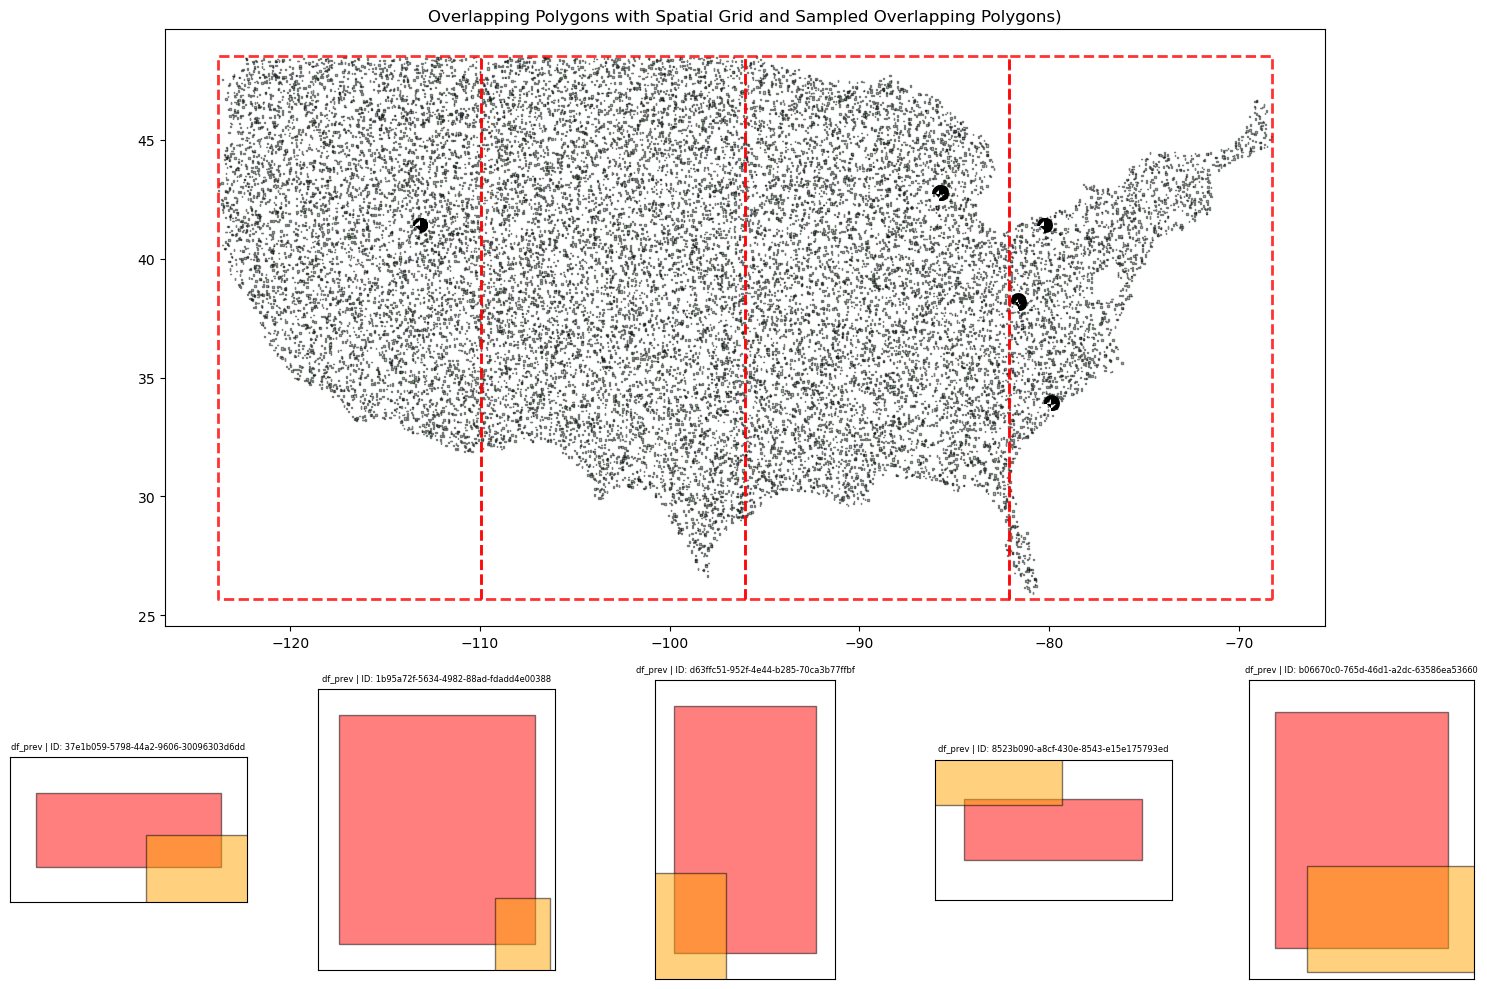

In [24]:
# --- Retrieve Data from PostgreSQL ---
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# --- Sample Overlapping Polygons ---
# Merge to ensure exact pairs before sampling
merged = matches.merge(overlapping_a, left_on="prev_id", right_on="id").merge(
    overlapping_b, left_on="curr_id", right_on="id", suffixes=("_prev", "_curr")
)

# Sample up to 5 matched pairs
sampled = merged.sample(n=min(5, len(merged)), random_state=42)

# debug
# print("Sampled columns:", sampled.columns)
# print("Overlapping_a columns:", overlapping_a.columns)
# print("Overlapping_b columns:", overlapping_b.columns)

# Extract individual DataFrames
sample_a = sampled[[col + "_prev" for col in overlapping_a.columns]]
sample_b = sampled[[col + "_curr" for col in overlapping_b.columns]]

# debug
# print("sample_a columns:", sample_a.columns)
# print("sample_b columns:", sample_b.columns)

# --- Define Figure Layout ---
fig = plt.figure(figsize=(15, 10))

# Main plot (2x height), subplots (1x height)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# --- Main Plot: Initial Polygons ---
ax_main = fig.add_subplot(gs[0])
df_prev.plot(ax=ax_main, color='lightblue', edgecolor='black', alpha=0.5, label="Previous", zorder=1)
df_curr.plot(ax=ax_main, color='lightgreen', edgecolor='black', alpha=0.5, label="Current", zorder=1)

# Highlight sampled polygons (plot the correct 'geometry' column directly)
sample_a.set_geometry('geometry_prev').plot(ax=ax_main, color='none', edgecolor='yellow', linewidth=0.01, linestyle='dashed', zorder=3)
sample_b.set_geometry('geometry_curr').plot(ax=ax_main, color='none', edgecolor='magenta', linewidth=0.01, linestyle='dashed', zorder=3)

# Emphasize selected polygons (plot the correct 'geometry' column directly)
sample_a.set_geometry('geometry_prev').plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)
sample_b.set_geometry('geometry_curr').plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)

ax_main.set_title("Overlapping Polygons with Spatial Grid and Sampled Overlapping Polygons)")

# --- Add spatial grid from parallel_matching process
spatial_grid = p.create_spatial_grid(df_prev, num_workers)
spatial_grid.boundary.plot(ax=ax_main, color='red', linewidth=2, linestyle="--", alpha=0.8, label="Grid Partitions")

# --- Dynamic Subplots (Centered Below) ---
sample_size = 5
gs_subplots = gridspec.GridSpecFromSubplotSpec(1, sample_size, subplot_spec=gs[1], wspace=0.3)

for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = fig.add_subplot(gs_subplots[0, i])
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    # Set geometry and plot explicitly by accessing the geometry
    subset_a = subset_a.set_geometry('geometry_prev')  # Ensure geometry is set
    subset_b = subset_b.set_geometry('geometry_curr')  # Ensure geometry is set

    # Plot the geometries explicitly
    subset_a.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)

    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]  # Explicitly use .geometry for bounds
    buffer = 0.01
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Titles & Aesthetics
    ax.set_title(f"df_prev | ID: {row['id_prev']}", fontsize=6)  # Use the appropriate ID column
    ax.set_xticks([])  
    ax.set_yticks([])

# Adjust layout and show
plt.tight_layout()

# plt.savefig('figs/overlapping_polygons_map_5k.pdf', bbox_inches='tight')
# plt.savefig('figs/overlapping_polygons_map_5k.png', bbox_inches='tight')

plt.savefig('figs/overlapping_polygons_map_10k.pdf', bbox_inches='tight')
plt.savefig('figs/overlapping_polygons_map_10k.png', bbox_inches='tight')

plt.show()

## 2. Optimized Approach

Having demonstrated a reasonable if not optimized way of matching polygons, we will now make use of geospatial-native tools to hopefully match polygons much more quickly.

My workflow centers around `DuckDB` and `H3` along with the `.parquet` format to efficiently store, retrieve, and process geospatial data. We will use `Apache Iceberg` as a layer over the parquet file as it allows for more robust table handling.

1. Prepare GeodataFrames with H3 Polyfill and parent hexagons at lower resolution.
   * Save as an Iceberg table.

2. Use DuckDB and the H3 extension to execute spatial SQL queries to find overlapping polygons with H3-based joins.

3. Save matching polygon IDs to a new Iceberg table.

4. Visualize the results.

### 2.1. Add H3 data to the blobs

H3 is a modern and efficient geospatial index paradigm that divides the world into nested hexagons.

In [25]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.17040 26.94651, -81.08065 26.946...",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u
1,"POLYGON ((-81.31626 27.17619, -81.30139 27.176...",dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c,dhy4tz
2,"POLYGON ((-81.45706 27.23212, -81.38565 27.232...",609e736e-86f3-4cf6-8431-f6c4e758e34c,dhy55j
3,"POLYGON ((-80.86148 27.33751, -80.77728 27.337...",060438ef-f5c2-4379-859d-9a2ee8086893,dhye8f
4,"POLYGON ((-81.18868 27.33882, -81.08989 27.338...",893f78cc-d272-4042-b7cd-f61afee7968a,dhy79e


In [26]:
# import duckdb
# importlib.reload(h)

# df_prev, df_curr = h.create_h3_info_parallel(df_prev=df_prev, df_curr=df_curr)

# df_prev.head(3)

In [28]:
importlib.reload(h)

iceberg_dir = Path("iceberg")
iceberg_dir.mkdir(parents=True, exist_ok=True)
print(df_prev.columns)
print(df_curr.columns)

df_prev, df_curr = h.create_h3_info_parallel_new(df_prev=df_prev, 
                                                 df_curr=df_curr,
                                                 iceberg_path=iceberg_dir)

df_prev.head(3)

Index(['geometry', 'id', 'geohash', 'geometry_wkt'], dtype='object')
Index(['geometry', 'id', 'geohash', 'geometry_wkt'], dtype='object')


/Applications/Anaconda/anaconda3/envs/geo/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Function `process_h3_info_chunk` executed in 0.4542 sec, CPU: 9.20%, Memory: 7.22MB
Function `process_h3_info_chunk` executed in 0.4827 sec, CPU: 9.00%, Memory: 6.80MB
Function `process_h3_info_chunk` executed in 0.4822 sec, CPU: 9.50%, Memory: 7.53MB
Function `process_h3_info_chunk` executed in 0.5032 sec, CPU: 8.80%, Memory: 9.23MB
Function `process_h3_info_chunk` executed in 0.4801 sec, CPU: 57.10%, Memory: 0.00MB
Function `process_h3_info_chunk` executed in 0.4942 sec, CPU: 9.30%, Memory: 38.52MB
Function `process_h3_info_chunk` executed in 0.5219 sec, CPU: 39.40%, Memory: 25.70MB
Function `process_h3_info_chunk` executed in 0.5230 sec, CPU: 64.10%, Memory: 25.48MB


ConnectionError: HTTPConnectionPool(host='localhost', port=8181): Max retries exceeded with url: /v1/config (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x175f3b510>: Failed to establish a new connection: [Errno 61] Connection refused'))

# Notes on original process

geohash polygon into a larger region
match blobs using multiprocessing (mp.Process) and geopandas
find blobs from previous month that do not have a match

# 1 imports and setup

```python
import os, sys, traceback
import argparse
import cv2
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io, color, measure
from tqdm import tqdm
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import PIL
from PIL import Image, ImageDraw, ImageEnhance
import uuid
import multiprocessing as mp
from datetime import datetime
from sqlalchemy import or_
from sqlmodel import SQLModel, Session, create_engine, select
from pathlib import Path
```

## Key takeaways
- Uses Pandas and GeoPandas for data processing.
- Uses Shapely for geospatial geometry operations.
- Uses multiprocessing (mp) to parallelize the blob-matching process.
- Uses SQLAlchemy and SQLModel for database operations.

# 2 High-level script overview
The script is designed to match blobs (spatial objects) between two months and classify them into different business categories.

General Workflow
1. Fetch blobs from the previous and current months.
1. Convert the region of interest (state, city, county, or geohash) into a list of geohashes.
1. Parallelized Matching Process:
1. Process multiple geohashes at once using multiprocessing.
1. Find corresponding blobs from previous months for each geohash.
1. Classify blobs based on construction stage progression.
1. Identify blobs that are missing in the current month and "impute" them.
1. Save results into the database.

# 3 Blob classification logic

# 4 Blob matching

- Matches blobs between months using polygon intersections.
- Uses Shapely to validate geometries and check for overlaps.
- Returns matched blob IDs.

## Multiprocessing Optimization
The script parallelizes blob matching by:
- Uses multiprocessing (mp.Process) to divide the dataset into smaller batches.
- Each batch of blobs is processed in parallel.
- Reduces runtime compared to a single-threaded approach.

# 5 Handling unmatched blobs
- Finds blobs from the previous month that do not have a match in the current month.
- These blobs are "imputed", meaning they are carried over into the new month.

# 6 Main class to orchestrate process
- Loads previous and current month blobs.
- Converts input regions (state, city, county) into geohashes.

# Summary
- Parallel processing is used to match blobs.
- Blobs are classified based on construction stages.
- Unmatched blobs are imputed for continuity.
- The script writes results to a database.